Importación de Librerias

In [ ]:
"""
SVM PARA CLASIFICACIÓN DE ENFERMEDADES DE CEBOLLA (Allium fistulosum)
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "SVM" #Carpeta para guardar y cargar los modelos de SVM
out_dir.mkdir(parents=True, exist_ok=True)

Función para cargar datos desde el CSV

In [5]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    El CSV debe tener al menos las columnas: 'image_path' y 'class'.
    """
    print("=" * 60)
    print("CARGANDO DATASET")
    print("=" * 60)

    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")

    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")

    X = []
    y = []
    errores = 0

    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])

            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')

            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten()
            imagen_normalizada = imagen_array / 255.0

            X.append(imagen_normalizada)
            y.append(fila['class'])

            if (idx + 1) % 100 == 0:
                print(f"   Procesadas {idx + 1} imágenes...")

        except Exception as e:
            errores += 1
            print(f"   [ERROR] No se pudo procesar la imagen en fila {idx}: {e}")

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal de imágenes procesadas correctamente: {len(X)}")
    print(f"Total de errores al cargar imágenes: {errores}")

    return X, y, clases_unicas

Función para optimizar los Hiperparametros

In [6]:
def optimizar_hiperparametros_svm(X_train, y_train, busqueda_rapida=True):
    """
    Optimiza los hiperparámetros de una SVM usando GridSearchCV.
    """
    print("\n" + "=" * 60)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS - SVM")
    print("=" * 60)

    modelo_base = SVC(probability=True, random_state=42)

    if busqueda_rapida:
        # Grid pequeño para no tardar demasiado
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    else:
        # Grid más amplio (puede ser costoso en tiempo)
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01, 0.001],
            'degree': [2, 3, 4],       # solo afecta a 'poly'
            'coef0': [0.0, 0.1, 0.5]   # útil en 'poly'
        }

    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print("\nMejores hiperparámetros encontrados:")
    for k, v in grid_search.best_params_.items():
        print(f"   {k}: {v}")

    print(f"\nMejor score de validación: {grid_search.best_score_:.4f}")

    return grid_search.best_params_

Función para Entrenar el Modelo

In [7]:
def entrenar_svm(X_train, y_train):
    print("\n" + "=" * 60)
    print("ENTRENANDO SVM (SIN GRIDSEARCH)")
    print("=" * 60)

    params_fijos = {
        'C': 10.0,
        'kernel': 'rbf',
        'gamma': 'scale',
        'class_weight': 'balanced',
        'probability': True,
        'random_state': 42
    }

    for k, v in params_fijos.items():
        print(f"   {k}: {v}")

    modelo = SVC(**params_fijos)
    modelo.fit(X_train, y_train)

    print("\nModelo SVM entrenado correctamente.")
    print(f"Número total de vectores de soporte: {modelo.n_support_.sum()}")
    print("Vectores de soporte por clase:", modelo.n_support_)

    return modelo


Función para Evaluar el Modelo

In [8]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas.
    """
    print("\n" + "=" * 60)
    print("EVALUACIÓN DEL MODELO - SVM")
    print("=" * 60)

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Accuracy global
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy * 100:.2f}%)")

    # Reporte detallado
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-" * 60)
    reporte = classification_report(
        y_test,
        y_pred,
        target_names=nombres_clases,
        zero_division=0
    )
    print(reporte)

    # Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    return accuracy, y_pred, matriz_confusion

Función para visualizar la matriz de confusión

In [27]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza la matriz de confusión.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matriz_confusion,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=nombres_clases,
        yticklabels=nombres_clases,
        cbar=True
    )
    plt.title('Matriz de Confusión - SVM', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_svm.png', dpi=100, bbox_inches='tight')
    plt.show()

Función Para visualizar el Margen del SVM

In [26]:
def analizar_margen_svm(modelo, X_train, y_train):
    """
    Analiza algunas propiedades del margen y de los vectores de soporte.
    (Análisis cualitativo, no es exactamente 'importancia de características').
    """
    print("\n" + "=" * 60)
    print("ANÁLISIS DE MARGEN Y VECTORES DE SOPORTE - SVM")
    print("=" * 60)

    n_sv_total = modelo.n_support_.sum()
    print(f"Número total de vectores de soporte: {n_sv_total}")
    print(f"Vectores de soporte por clase: {modelo.n_support_}")

    try:
        decision_values = modelo.decision_function(X_train)
        if decision_values.ndim == 1:
            distancias = np.abs(decision_values)
        else:
            # Para multi-clase (one-vs-one): tomar norma
            distancias = np.linalg.norm(decision_values, axis=1)

        print(f"\nDistancia al hiperplano (aprox. margen) - estadísticas:")
        print(f"   Mínima:  {distancias.min():.4f}")
        print(f"   Máxima:  {distancias.max():.4f}")
        print(f"   Media:   {distancias.mean():.4f}")
        print(f"   Mediana: {np.median(distancias):.4f}")

        plt.figure(figsize=(10, 6))
        plt.hist(distancias, bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel('Distancia aproximada al hiperplano')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de distancias al hiperplano (margen) - SVM')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(out_dir/'distribucion_margen_svm.png', dpi=100, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"No se pudo calcular decision_function para analizar el margen: {e}")

Función para Predecir una nueva Imagen

In [39]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_svm.pkl'):
    """
    Predice la clase de una nueva imagen usando la SVM entrenada.

    Parámetros
    ----------
    ruta_imagen : str
        Ruta a la imagen que se quiere clasificar.
    modelo_path : str
        Ruta al modelo guardado.

    Returns
    -------
    str : Clase predicha
    """
    try:
        import matplotlib.pyplot as plt  # Import aquí por si no está en el global

        print("\n" + "=" * 60)
        print("PREDICCIÓN PARA UNA NUEVA IMAGEN (SVM)")
        print("=" * 60)

        # Cargar modelo y LabelEncoder
        modelo = joblib.load(modelo_path)
        label_encoder = joblib.load(out_dir/'label_encoder_svm.pkl')

        # Cargar imagen original (para mostrarla)
        imagen_original = Image.open(ruta_imagen)

        # Procesar imagen para el modelo
        imagen = imagen_original
        if imagen.mode != 'RGB':
            imagen = imagen.convert('RGB')
        imagen = imagen.resize((32, 32))
        imagen_array = np.array(imagen).flatten() / 255.0
        imagen_array = imagen_array.reshape(1, -1)

        # Predicción
        prediccion = modelo.predict(imagen_array)[0]

        # Probabilidades (requiere probability=True al entrenar)
        if hasattr(modelo, "predict_proba"):
            probabilidades = modelo.predict_proba(imagen_array)[0]
            confianza = float(np.max(probabilidades))
        else:
            probabilidades = None
            confianza = None

        clase_predicha = label_encoder.inverse_transform([prediccion])[0]

        # Imprimir resultados
        print(f"\nClase predicha: {clase_predicha}")
        if confianza is not None:
            print(f"Confianza: {confianza:.2%}")

        if probabilidades is not None:
            indices_top = np.argsort(probabilidades)[::-1][:3]
            print("\nTop 3 predicciones:")
            for i, idx in enumerate(indices_top):
                clase = label_encoder.inverse_transform([idx])[0]
                prob = probabilidades[idx]
                print(f"   {i + 1}. {clase}: {prob:.2%}")

        # Mostrar la imagen con la clase predicha y confianza
        plt.figure(figsize=(4, 4))
        plt.imshow(imagen_original)
        plt.axis('off')

        if confianza is not None:
            titulo = f"Predicción (SVM): {clase_predicha}\nConfianza: {confianza*100:.2f}%"
        else:
            titulo = f"Predicción (SVM): {clase_predicha}"

        plt.title(titulo)
        plt.tight_layout()
        plt.show()

        return clase_predicha

    except Exception as e:
        print(f"ERROR: {e}")
        return None

Parametros del Modelo

In [12]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2
OPTIMIZAR_PARAMS = False  # Falso para no optimizar los hiperparametros

In [13]:
# 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight
   Procesadas 100 imágenes...
   Procesadas 200 imágenes...
   Procesadas 300 imágenes...
   Procesadas 400 imágenes...
   Procesadas 500 imágenes...
   Procesadas 600 imágenes...
   Procesadas 700 imágenes...
   Procesadas 800 imágenes...
   Procesadas 900 imágenes...
   Procesadas 1000 imágenes...
   Procesadas 1100 imágenes...
   Procesadas 1200 imágenes...
   Procesadas 1300 imágenes...
   Procesadas 1400 imágenes...
   Procesadas 1500 imágenes...
   Procesadas 1600 imágenes...
   Procesadas 1700 imágenes...
   Procesadas 1800 imágenes...
   Procesadas 1900 imágenes...
   Procesadas 20

In [16]:
# 2. Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [19]:
# 3. Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_encoded
)

print(f"\nTamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de prueba: {X_test.shape[0]} muestras")


Tamaño de entrenamiento: 10583 muestras
Tamaño de prueba: 2646 muestras


In [20]:
# 4. Entrenar modelo
modelo = entrenar_svm(X_train, y_train)


ENTRENANDO SVM (SIN GRIDSEARCH)
   C: 10.0
   kernel: rbf
   gamma: scale
   class_weight: balanced
   probability: True
   random_state: 42

Modelo SVM entrenado correctamente.
Número total de vectores de soporte: 8887
Vectores de soporte por clase: [ 451  230    6   27  735   30  806 2561 1483  657  164  278  151   52
 1256]


In [21]:
# 5. Evaluación del modelo
accuracy, y_pred, matriz = evaluar_modelo(
    modelo,
    X_test,
    y_test,
    nombres_clases=label_encoder.classes_
)


EVALUACIÓN DEL MODELO - SVM

ACCURACY GENERAL: 0.7449 (74.49%)

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.80      0.69      0.74       166
     Botrytis Leaf Blight       0.57      0.66      0.61        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       1.00      0.97      0.99        79
            Caterpillar-P       0.91      0.93      0.92       312
             Downy mildew       0.00      0.00      0.00         7
               Fusarium-D       0.80      0.82      0.81       255
           Healthy leaves       0.73      0.76      0.75       688
Iris yellow virus_augment       0.55      0.59      0.57       380
            Purple blotch       0.90      0.84      0.87       170
                     Rust       0.55      0.63      0.59        43
                Virosis-D       0.96    

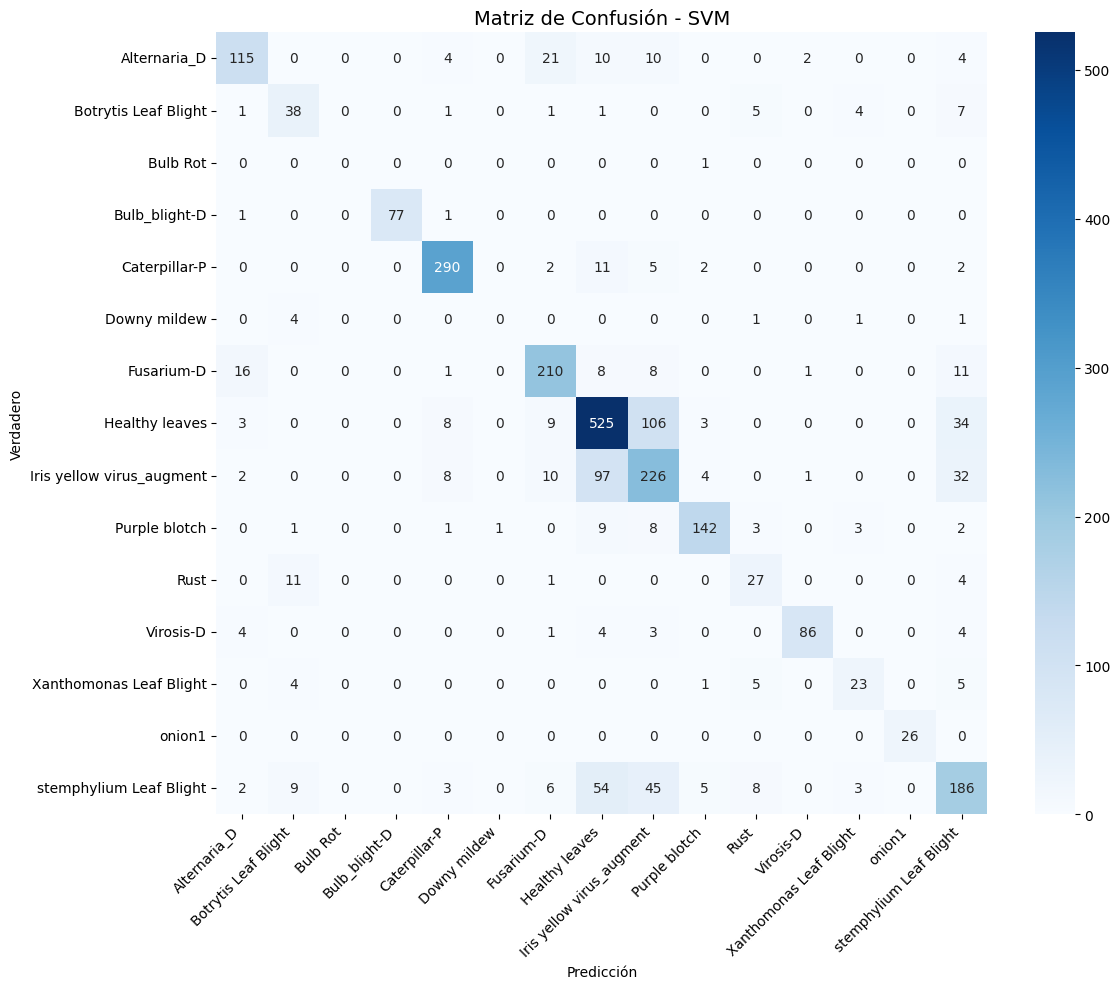

In [28]:
# 6. Visualizar Matriz de Confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)


ANÁLISIS DE MARGEN Y VECTORES DE SOPORTE - SVM
Número total de vectores de soporte: 8887
Vectores de soporte por clase: [ 451  230    6   27  735   30  806 2561 1483  657  164  278  151   52
 1256]

Distancia al hiperplano (aprox. margen) - estadísticas:
   Mínima:  31.9565
   Máxima:  32.5790
   Media:   32.3852
   Mediana: 32.3816


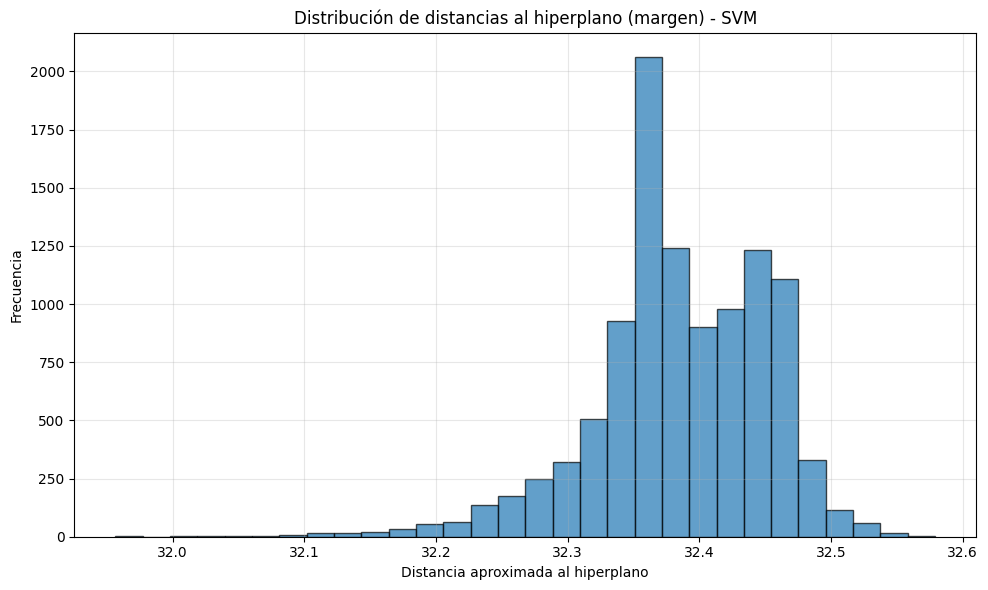

In [29]:
# 7. Visualizar Margen SVM
analizar_margen_svm(modelo, X_train, y_train)

In [24]:
# 8. Guardar modelo y label encoder
joblib.dump(modelo, out_dir/'modelo_svm.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_svm.pkl')
print("\nModelo SVM y LabelEncoder guardados en disco.")


Modelo SVM y LabelEncoder guardados en disco.


In [30]:
# 9. Accuracy por clase
print("\n" + "=" * 60)
print("ACCURACY POR CLASE")
print("=" * 60)

accuracies_por_clase = []
for i, clase in enumerate(label_encoder.classes_):
    idx = np.where(y_test == i)[0]
    if len(idx) == 0:
        acc_clase = 0.0
    else:
        acc_clase = accuracy_score(y_test[idx], y_pred[idx])
    accuracies_por_clase.append(acc_clase)
    print(f"   {clase}: {acc_clase:.2%}")


ACCURACY POR CLASE
   Alternaria_D: 69.28%
   Botrytis Leaf Blight: 65.52%
   Bulb Rot: 0.00%
   Bulb_blight-D: 97.47%
   Caterpillar-P: 92.95%
   Downy mildew: 0.00%
   Fusarium-D: 82.35%
   Healthy leaves: 76.31%
   Iris yellow virus_augment: 59.47%
   Purple blotch: 83.53%
   Rust: 62.79%
   Virosis-D: 84.31%
   Xanthomonas Leaf Blight: 60.53%
   onion1: 100.00%
   stemphylium Leaf Blight: 57.94%


Predicción de Imagenes con el Modelo


PREDICCIÓN PARA UNA NUEVA IMAGEN (SVM)

Clase predicha: Alternaria_D
Confianza: 90.85%

Top 3 predicciones:
   1. Alternaria_D: 90.85%
   2. Fusarium-D: 2.11%
   3. Healthy leaves: 2.01%


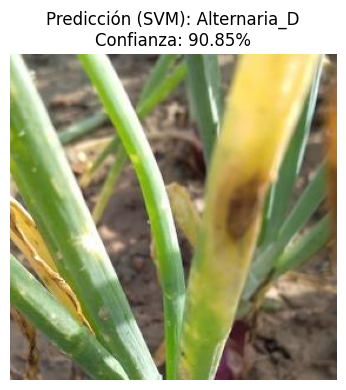

'Alternaria_D'

In [40]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN (SVM)

Clase predicha: Botrytis Leaf Blight
Confianza: 46.99%

Top 3 predicciones:
   1. Botrytis Leaf Blight: 46.99%
   2. Rust: 21.29%
   3. stemphylium Leaf Blight: 20.00%


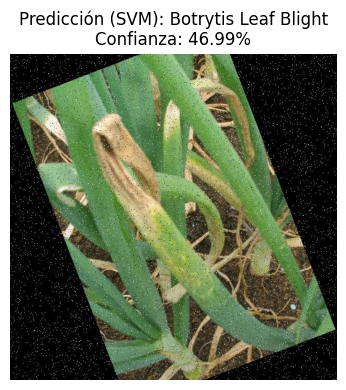

'Botrytis Leaf Blight'

In [41]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN (SVM)

Clase predicha: Iris yellow virus_augment
Confianza: 78.95%

Top 3 predicciones:
   1. Iris yellow virus_augment: 78.95%
   2. Healthy leaves: 13.78%
   3. Caterpillar-P: 1.61%


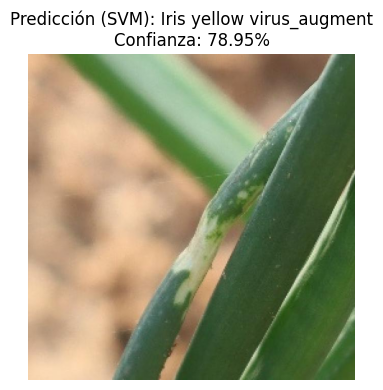

'Iris yellow virus_augment'

In [42]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN (SVM)

Clase predicha: Purple blotch
Confianza: 96.56%

Top 3 predicciones:
   1. Purple blotch: 96.56%
   2. Iris yellow virus_augment: 1.08%
   3. Healthy leaves: 0.80%


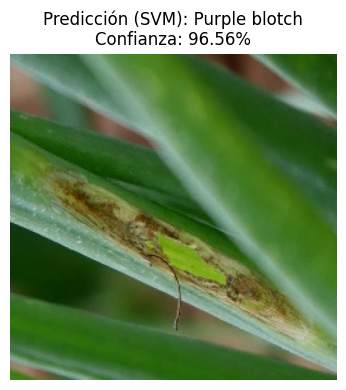

'Purple blotch'

In [43]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")